In [8]:
pip install antropy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
#-*- coding: utf-8 -*-
import librosa
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
import warnings 
import sklearn
import matplotlib.pyplot as plt
import antropy
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from scipy.stats import yeojohnson
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

warnings.filterwarnings("ignore")

In [10]:
# types of models pls = Partial Least Square Regression or lr or lr_pca
# apply_transformation (default=True):A boolean indicating whether to apply the Yeo-Johnson transformation to normalize the feature set.
# toPredict (default=['valence', 'energy', 'tension']): A list of target variables (emotion dimensions) to predict.

def run_model(feature_set, model='pls', apply_transformation=True, toPredict=['valence', 'energy', 'tension']):
  feature_set.dropna(how = 'any', axis = 0) 
  audio_df = pd.read_csv('features_combined.csv')
  # audio_df.drop(['Unnamed: 0'], axis = 1, inplace = True)
  audio_df = audio_df.dropna(how = 'any',axis = 0)
  X = audio_df.loc[:, "tempo" : "frame_var"]
  featureName = X.columns.tolist()
  if apply_transformation == True:
    for name in featureName:
      if isinstance(feature_set[name].iloc[0], (list, np.ndarray)):
        feature_set[name] = feature_set[name].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) else x)
      X[name], lam = yeojohnson(X[name])  # Transform the training set
      feature_set[name] = yeojohnson(feature_set[name], lmbda=lam)
  
  # Prepare results
  X = pd.DataFrame(X)
  emotionRatingPrediction = {}
  r2s = {}

  for target in toPredict:
    y = audio_df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    if model == "pls":
        pls = PLSRegression(n_components=10)
        pls.fit(X_train, y_train)
        y_pred = pls.predict(X_test).flatten()
        r2 = pls.score(X_train, y_train)
        pred = pls.predict(feature_set)
    elif model == "lr" or model == "lr_pca":
        reg = linear_model.LinearRegression()
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test).flatten()
        r2 = reg.score(X_train, y_train)
        pred = reg.predict(feature_set)
    elif model == "lr_pca":
        pca = PCA(n_components=11)
        X_train_transformed = pca.fit_transform(X_train)
        X_test_transformed = pca.transform(X_test)
        feature_set_transformed = pca.transform(feature_set)
        reg = linear_model.LinearRegression()
        reg.fit(X_train_transformed, y_train)
        y_pred = reg.predict(X_test_transformed).flatten()
        r2 = reg.score(X_train_transformed, y_train)
        pred = reg.predict(feature_set_transformed)

    # Compute Classification Report
    y_true_binned = np.digitize(y_test, bins=np.linspace(y_test.min(), y_test.max(), 5))
    y_pred_binned = np.digitize(y_pred, bins=np.linspace(y_test.min(), y_test.max(), 5))

    print(f"Classification Report for {target}:")
    print(classification_report(y_true_binned, y_pred_binned))

    emotionRatingPrediction[target] = pred.flatten()
    r2s[target] = r2 # Update with correct r2 computation

  return emotionRatingPrediction, r2s


In [11]:
def extract_features(audio):
    feature_set = pd.DataFrame()
    vectors = {
        'tempo': [], 'total_beats': [], 'average_beats': [], 'chroma_stft_mean': [], 'chroma_stft_std': [], 'chroma_stft_var': [],
        'chroma_cq_mean': [], 'chroma_cq_std': [], 'chroma_cq_var': [], 'chroma_cens_mean': [], 'chroma_cens_std': [],
        'chroma_cens_var': [], 'melspectrogram_mean': [], 'melspectrogram_std': [], 'melspectrogram_var': [], 'mfcc_mean': [], 'mfcc_std': [],
        'mfcc_var': [], 'mfcc_delta_mean': [], 'mfcc_delta_std': [], 'mfcc_delta_var': [], 'rms_mean': [], 'rms_std': [],
        'rms_var': [], 'cent_mean': [], 'cent_std': [], 'cent_var': [], 'spec_bw_mean': [], 'spec_bw_std': [],
        'spec_bw_var': [], 'contrast_mean': [], 'contrast_std': [], 'contrast_var': [], 'rolloff_mean': [],
        'rolloff_std': [], 'rolloff_var': [], 'entropy_fft': [], 'entropy_welch': [], 'novelty_mean': [], 'novelty_std': [],
        'novelty_var': [], 'poly_mean': [], 'poly_std': [], 'poly_var': [], 'tonnetz_mean': [], 'tonnetz_std': [],
        'tonnetz_var': [], 'zcr_mean': [], 'zcr_std': [], 'zcr_var': [], 'harm_mean': [], 'harm_std': [], 'harm_var': [],
        'perc_mean': [], 'perc_std': [], 'perc_var': [], 'frame_mean': [], 'frame_std': [], 'frame_var': []
    }

    y, sr = librosa.load(audio)
    S = np.abs(librosa.stft(y))
    time = 0

    while time < len(y) - sr * 10:
        curr = y[time:min(len(y), time + 10 * sr)]
        time += sr * 10

        # Feature Extraction
        tempo, beats = librosa.beat.beat_track(y=curr, sr=sr)
        vectors['tempo'].append(tempo)
        vectors['total_beats'].append(sum(beats))
        vectors['average_beats'].append(np.average(beats) if len(beats) > 0 else 0)

        chroma_stft = librosa.feature.chroma_stft(y=curr, sr=sr)
        vectors['chroma_stft_mean'].append(np.mean(chroma_stft))
        vectors['chroma_stft_std'].append(np.std(chroma_stft))
        vectors['chroma_stft_var'].append(np.var(chroma_stft))

        chroma_cq = librosa.feature.chroma_cqt(y=curr, sr=sr)
        vectors['chroma_cq_mean'].append(np.mean(chroma_cq))
        vectors['chroma_cq_std'].append(np.std(chroma_cq))
        vectors['chroma_cq_var'].append(np.var(chroma_cq))

        chroma_cens = librosa.feature.chroma_cens(y=curr, sr=sr)
        vectors['chroma_cens_mean'].append(np.mean(chroma_cens))
        vectors['chroma_cens_std'].append(np.std(chroma_cens))
        vectors['chroma_cens_var'].append(np.var(chroma_cens))

        mel = librosa.feature.melspectrogram(y=curr, sr=sr)
        vectors['melspectrogram_mean'].append(np.mean(mel))
        vectors['melspectrogram_std'].append(np.std(mel))
        vectors['melspectrogram_var'].append(np.var(mel))

        mfcc = librosa.feature.mfcc(y=curr, sr=sr)
        vectors['mfcc_mean'].append(np.mean(mfcc))
        vectors['mfcc_std'].append(np.std(mfcc))
        vectors['mfcc_var'].append(np.var(mfcc))

        mfcc_delta = librosa.feature.delta(mfcc)
        vectors['mfcc_delta_mean'].append(np.mean(mfcc_delta))
        vectors['mfcc_delta_std'].append(np.std(mfcc_delta))
        vectors['mfcc_delta_var'].append(np.var(mfcc_delta))

        rms = librosa.feature.rms(y=curr)
        vectors['rms_mean'].append(np.mean(rms))
        vectors['rms_std'].append(np.std(rms))
        vectors['rms_var'].append(np.var(rms))

        cent = librosa.feature.spectral_centroid(y=curr, sr=sr)
        vectors['cent_mean'].append(np.mean(cent))
        vectors['cent_std'].append(np.std(cent))
        vectors['cent_var'].append(np.var(cent))

        spec_bw = librosa.feature.spectral_bandwidth(y=curr, sr=sr)
        vectors['spec_bw_mean'].append(np.mean(spec_bw))
        vectors['spec_bw_std'].append(np.std(spec_bw))
        vectors['spec_bw_var'].append(np.var(spec_bw))

        contrast = librosa.feature.spectral_contrast(y=curr, sr=sr)
        vectors['contrast_mean'].append(np.mean(contrast))
        vectors['contrast_std'].append(np.std(contrast))
        vectors['contrast_var'].append(np.var(contrast))

        rolloff = librosa.feature.spectral_rolloff(y=curr, sr=sr)
        vectors['rolloff_mean'].append(np.mean(rolloff))
        vectors['rolloff_std'].append(np.std(rolloff))
        vectors['rolloff_var'].append(np.var(rolloff))

        entropy_fft = antropy.perm_entropy(curr)
        vectors['entropy_fft'].append(entropy_fft)

        entropy_welch = antropy.welch(curr)
        vectors['entropy_welch'].append(entropy_welch)

        novelty = librosa.onset.onset_strength(y=curr, sr=sr)
        vectors['novelty_mean'].append(np.mean(novelty))
        vectors['novelty_std'].append(np.std(novelty))
        vectors['novelty_var'].append(np.var(novelty))

        poly = librosa.feature.spectral_flatness(y=curr)
        vectors['poly_mean'].append(np.mean(poly))
        vectors['poly_std'].append(np.std(poly))
        vectors['poly_var'].append(np.var(poly))

        tonnetz = librosa.feature.tonnetz(y=curr, sr=sr)
        vectors['tonnetz_mean'].append(np.mean(tonnetz))
        vectors['tonnetz_std'].append(np.std(tonnetz))
        vectors['tonnetz_var'].append(np.var(tonnetz))

        zcr = librosa.feature.zero_crossing_rate(y=curr)
        vectors['zcr_mean'].append(np.mean(zcr))
        vectors['zcr_std'].append(np.std(zcr))
        vectors['zcr_var'].append(np.var(zcr))

        harm = librosa.effects.hpss(curr)[0]
        vectors['harm_mean'].append(np.mean(harm))
        vectors['harm_std'].append(np.std(harm))
        vectors['harm_var'].append(np.var(harm))

        perc = librosa.effects.hpss(curr)[1]
        vectors['perc_mean'].append(np.mean(perc))
        vectors['perc_std'].append(np.std(perc))
        vectors['perc_var'].append(np.var(perc))

        # Frame statistics
        frame = librosa.feature.rms(y=curr)
        vectors['frame_mean'].append(np.mean(frame))
        vectors['frame_std'].append(np.std(frame))
        vectors['frame_var'].append(np.var(frame))

    feature_set = pd.DataFrame([vectors])
    return feature_set

    

In [12]:
def interpret_emotion(predictions):
    """
    Interprets emotion predictions and returns emotional characteristics.
    Parameters:
        predictions: dict with 'valence', 'energy', and 'tension' values
    Returns:
        str: Emotional interpretation
    """
    valence = predictions['valence'][0]
    energy = predictions['energy'][0]
    tension = predictions['tension'][0]
    
    # Normalize values to 0-10 scale if they aren't already
    if valence > 10: valence = valence / max(predictions['valence']) * 10
    if energy > 10: energy = energy / max(predictions['energy']) * 10
    if tension > 10: tension = tension / max(predictions['tension']) * 10
    
    # Base emotional characteristics
    mood = "neutral"
    intensity = "moderate"
    atmosphere = "balanced"
    
    # Interpret valence (positivity/negativity)
    if valence >= 7:
        mood = "very positive"
    elif valence >= 5:
        mood = "positive"
    elif valence <= 3:
        mood = "negative"
    elif valence < 5:
        mood = "slightly negative"
        
    # Interpret energy
    if energy >= 7:
        intensity = "high-energy"
    elif energy <= 3:
        intensity = "low-energy"
        
    # Interpret tension
    if tension >= 7:
        atmosphere = "tense"
    elif tension <= 3:
        atmosphere = "relaxed"
        
    # Combine interpretations
    specific_emotions = []
    if valence >= 6 and energy >= 6:
        specific_emotions.append("joyful")
    if valence <= 4 and tension >= 6:
        specific_emotions.append("anxious")
    if energy <= 4 and tension <= 4:
        specific_emotions.append("calm")
    if valence <= 4 and energy >= 6:
        specific_emotions.append("angry")
        
    emotion_str = f"This music appears to be {mood} and {intensity} with a {atmosphere} atmosphere."
    if specific_emotions:
        emotion_str += f" The emotional quality suggests: {', '.join(specific_emotions)}."
        
    return emotion_str

In [13]:
def visualize_emotions(predictions):
    """
    Creates visualization dashboard for emotion predictions using matplotlib
    """
    fig = plt.figure(figsize=(15, 5))
    
    # Bar Plot
    ax1 = fig.add_subplot(131)
    emotions = ['Valence', 'Energy', 'Tension']
    values = [predictions['valence'][0], predictions['energy'][0], predictions['tension'][0]]
    ax1.bar(emotions, values, color=['blue', 'green', 'red'])
    ax1.set_title('Emotion Values')
    ax1.set_ylim(0, 10)
    
    # Radar Plot
    ax2 = fig.add_subplot(132, projection='polar')
    angles = np.linspace(0, 2*np.pi, len(emotions), endpoint=False)
    values = np.concatenate((values, [values[0]]))  # Repeat first value
    angles = np.concatenate((angles, [angles[0]]))  # Repeat first angle
    ax2.plot(angles, values)
    ax2.fill(angles, values, alpha=0.25)
    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels(emotions)
    ax2.set_title('Emotion Radar')
    
    # 3D Plot
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.scatter(predictions['valence'], predictions['energy'], predictions['tension'])
    ax3.set_xlabel('Valence')
    ax3.set_ylabel('Energy')
    ax3.set_zlabel('Tension')
    ax3.set_title('3D Emotion Space')
    
    plt.tight_layout()
    plt.show()

Classification Report for valence:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.33      0.50         6
           2       0.20      0.25      0.22         4
           3       0.33      0.14      0.20         7
           4       0.33      0.75      0.46         4
           5       0.00      0.00      0.00         1

    accuracy                           0.32        22
   macro avg       0.31      0.25      0.23        22
weighted avg       0.48      0.32      0.32        22

Classification Report for energy:
              precision    recall  f1-score   support

           1       1.00      0.67      0.80         6
           2       0.75      0.75      0.75         8
           3       0.50      0.67      0.57         3
           4       0.80      1.00      0.89         4
           5       1.00      1.00      1.00         1

    accuracy                           0.77        22
   macro

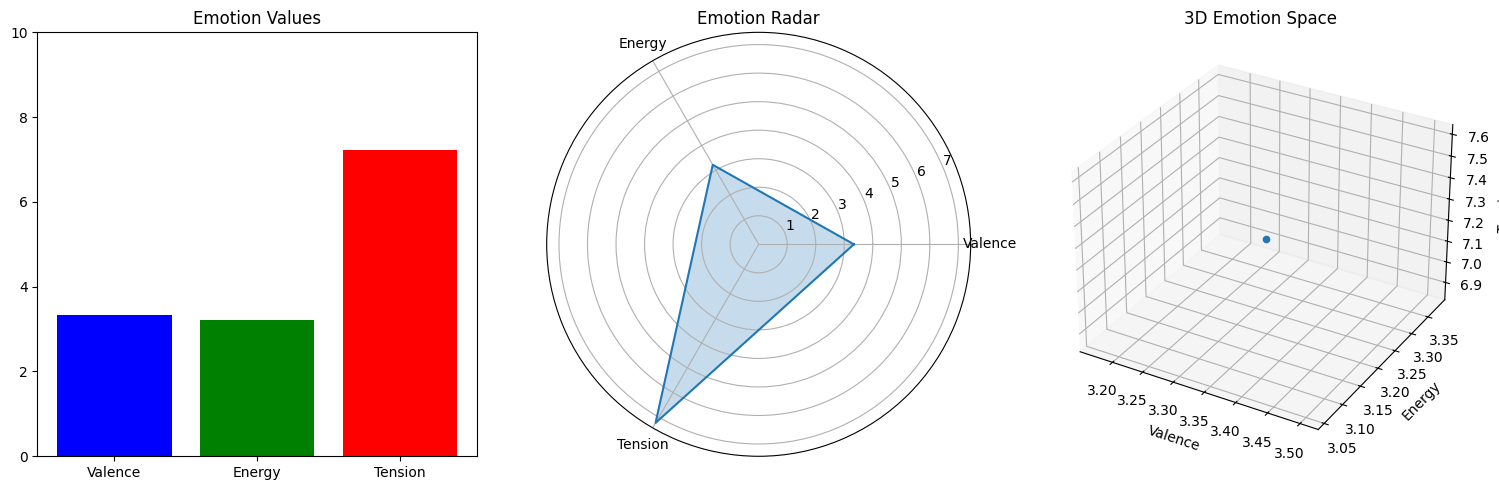

In [14]:
def main():
    audio_file_path = "deeper-rap-beat-instrumental-209903.mp3"
    feature_set = extract_features(audio_file_path)
    predictions, scores = run_model(feature_set, model="pls")
    
    print("\nPredictions:")
    print(pd.DataFrame(predictions))
    print("\nModel R^2 Scores:")
    print(scores)
    
    emotion_analysis = interpret_emotion(predictions)
    print("\nEmotion Analysis:")
    print(emotion_analysis)
    
    # Add visualization
    visualize_emotions(predictions)


if __name__ == "__main__":
    main()
